# Transaction Data Analysis Project

**Author:** Golbarg Ghazinour  
**Date:** December 2025
**Dataset:** Iranian Transaction Data (10,000 records)

## Project Goals
- Clean messy transaction data
- Load into MySQL database
- Analyze success rates, patterns by city and card type
- Practice SQL and Python for data analyst role

In [1]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 1: Load and Explore Raw Data

Loading the transaction dataset to understand its structure and identify data quality issues.

In [2]:
import os
print("Current directory:", os.getcwd())

Current directory: /Users/golbargghazinour/Desktop/project/Dirty-Iranian-Transactions


In [3]:
df = pd.read_csv('trx-10k.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (10000, 6)

First few rows:


,status,time,card_type,city,amount,id
0,success,2025-09-07 10:48:00,Visa,Tehran,1427657.0,98
1,success,2025-09-20 13:10:00,MastCard,Tehran,1578078.0,52
2,fail,2025-09-29 03:27:00,Visa,Tehran,250000.0,20
3,success,2025-09-15 13:13:00,Discover,Isfahan,0.0,40
4,success,2025-09-11 11:11:00,Visa,Tehran,1782689.0,59


In [4]:
print("Unique values in each column:\n")
print("Status:", df['status'].unique())
print("\nCard types:", df['card_type'].unique())
print("\nCities:", df['city'].unique())

Unique values in each column:

Status: ['success' 'fail' 'Success' 'failed' 'succeed' 'FAIL']

Card types: ['Visa' 'MastCard' 'Discover' 'Master-Card' 'Amex' 'visa' 'MasterCard' nan
 'Vsa' 'VISA' 'Master Card']

Cities: ['Tehran' 'Tehran ' 'Isfahan' 'Tabriz' 'Shiraz' 'TEHRAN' 'karaj' 'Ahvaz'
 'THR' 'Qom' 'Mashhad' 'tehr@n' 'Karaj' nan 'ThRan']


## Step 2: Data Cleaning

The data has several quality issues:
- **Status:** Multiple spellings (success/Success/succeed, fail/failed/FAIL)
- **Card types:** Inconsistent naming (MasterCard/Master-Card/MastCard, visa/Visa/VISA)
- **Cities:** Variations of same city (Tehran/TEHRAN/THR/tehr@n)
- **Missing values:** Some card_type and city values are NaN

Let's fix everything.

In [5]:
df_clean = df.copy()
df_clean['status'] = df_clean['status'].str.lower()

df_clean['status'] = df_clean['status'].replace('failed', 'fail')
df_clean['status'] = df_clean['status'].replace('succeed', 'success')

df_clean['card_type'] = df_clean['card_type'].str.lower()

df_clean['card_type'] = df_clean['card_type'].replace({
'mastcard': 'mastercard',
'master-card': 'mastercard',
'master card':'mastercard'})

df_clean['card_type'] = df_clean['card_type'].replace('vsa', 'visa')

df_clean['city'] = df_clean['city'].str.lower()
df_clean['city'] = df_clean['city'].str.strip()

df_clean['city'] = df_clean['city'].replace({
'thr': 'tehran',
'tehr@n': 'tehran',
'thran': 'tehran'
})

df_clean = df_clean.where(pd.notna(df_clean), None)

print("Cleaned status values:", df_clean['status'].unique())
print("Cleaned card type values:", df_clean['card_type'].unique())
print("Cleaned city values:", df_clean['city'].unique())


Cleaned status values: ['success' 'fail']
Cleaned card type values: ['visa' 'mastercard' 'discover' 'amex' None]
Cleaned city values: ['tehran' 'isfahan' 'tabriz' 'shiraz' 'karaj' 'ahvaz' 'qom' 'mashhad' None]


In [6]:
df_clean = df_clean.drop('id', axis=1)
df_clean['transaction_id']= range(1, len(df_clean) + 1)

print(f"Created {len(df_clean)} unique transaction IDs")
df_clean.head()

Created 10000 unique transaction IDs


,status,time,card_type,city,amount,transaction_id
0,success,2025-09-07 10:48:00,visa,tehran,1427657.0,1
1,success,2025-09-20 13:10:00,mastercard,tehran,1578078.0,2
2,fail,2025-09-29 03:27:00,visa,tehran,250000.0,3
3,success,2025-09-15 13:13:00,discover,isfahan,0.0,4
4,success,2025-09-11 11:11:00,visa,tehran,1782689.0,5


## Step 3: Load Data into MySQL

Creating a database and loading the cleaned data for SQL analysis.

In [7]:
'''
cursor.execute("TURNCATE TABLE transactions;")

sql_query = """INSERT INTO transactions
(transaction_id, status, time, card_type, city, amount)
VALUES(%s, %s, %s, %s, %s, %s);"""

for index, row in df_clean.iterrows():
    cursor.execute(sql_query, (
        row['transaction_id'], 
        row['status'], 
        row['time'], 
        row['card_type'], 
        row['city'], 
        row['amount']
    ))

cnx.commit()
print("Data loaded successfully!")
'''

print("Data already in database - skipping insert")

Data already in database - skipping insert


## Step 4: Data Analysis with SQL

Answer key business questions about the transactions.

In [8]:
def run_query(query):
    """Run SQL query with fresh connection"""
    # Create fresh connection each time
    connection = mysql.connector.connect(
        user='root', 
        password='pass245word',
        host='localhost',
        database='transactions_db'
    )
    
    result = pd.read_sql(query, connection)
    connection.close()
    return result

### Question 1: What is the transaction success rate?

In [9]:
query1 = """
SELECT 
    ROUND(AVG(CASE WHEN status = 'success' THEN 1 ELSE 0 END) * 100, 2) AS success_rate
FROM transactions;
"""

result = run_query(query1)
print(f"Success Rate: {result['success_rate'][0]}%")
result

Success Rate: 46.34%


/var/folders/jl/0pcs15c1273ff7zrhldsn30c0000gn/T/ipykernel_78313/1750610296.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(query, connection)


,success_rate
0,46.34


### Question 2: Which city has the most transactions?

In [10]:
query2 = """
SELECT city, COUNT(city) AS transaction_count
FROM transactions
GROUP BY city
ORDER BY transaction_count DESC
LIMIT 5;  -- Top 5 cities instead of just 1
"""

result = run_query(query2)
print("Top 5 cities by transaction volume:")
result

Top 5 cities by transaction volume:


/var/folders/jl/0pcs15c1273ff7zrhldsn30c0000gn/T/ipykernel_78313/1750610296.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(query, connection)


,city,transaction_count
0,tehran,3478
1,tabriz,1368
2,isfahan,1073
3,karaj,1037
4,mashhad,900


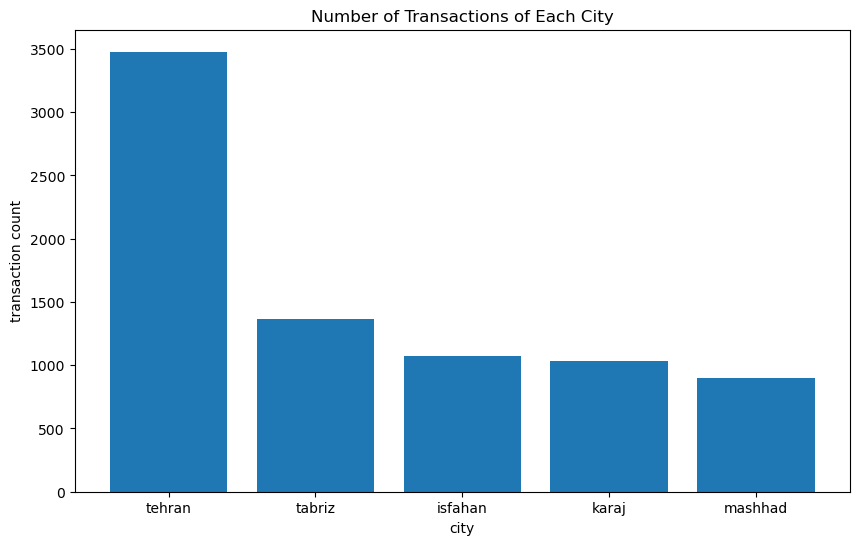

In [11]:
plt.figure(figsize=(10,6))
plt.bar(result['city'], result['transaction_count'])
plt.xlabel('city')
plt.ylabel('transaction count')
plt.title('Number of Transactions of Each City')
plt.show()

### Question 3: Which card type has the highest success rate?

In [12]:
query_card = """
SELECT 
    card_type, 
    ROUND(AVG(CASE WHEN status = 'success' THEN 1 ELSE 0 END) * 100, 2) AS success_rate,
    COUNT(*) as transaction_count
FROM transactions
WHERE card_type IS NOT NULL
GROUP BY card_type
ORDER BY success_rate DESC;
"""

df_card = run_query(query_card)
df_card

/var/folders/jl/0pcs15c1273ff7zrhldsn30c0000gn/T/ipykernel_78313/1750610296.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(query, connection)


,card_type,success_rate,transaction_count
0,amex,46.71,1263
1,mastercard,46.57,3234
2,discover,46.27,1647
3,visa,45.98,3545


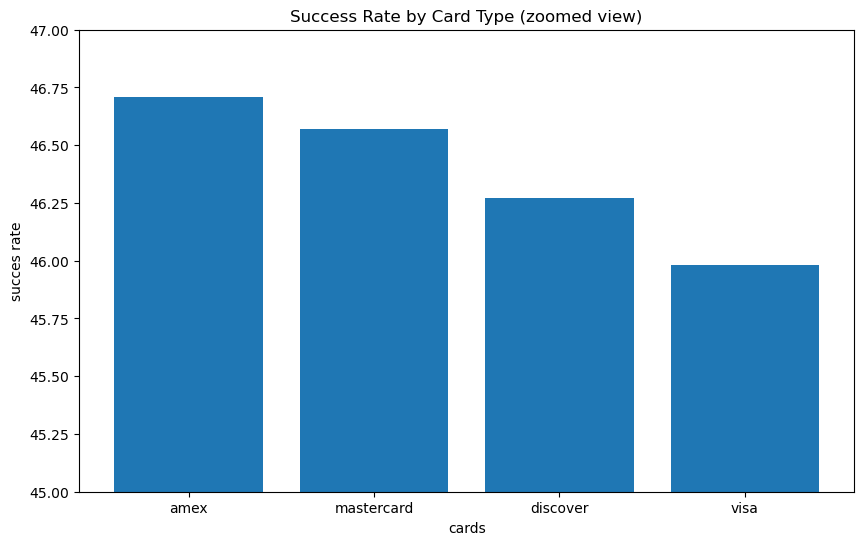

In [13]:
plt.figure(figsize=(10,6))
plt.bar(df_card['card_type'],df_card['success_rate'])
plt.ylim(45,47)
plt.xlabel('cards')
plt.ylabel('succes rate')
plt.title('Success Rate by Card Type (zoomed view)')
plt.show()

### Question 4: What percentage of transactions use each card type?

In [14]:
query_card_dist = """
SELECT card_type, COUNT(*) as count
FROM transactions
WHERE card_type IS NOT NULL
GROUP BY card_type;
"""

df_card_dist = run_query(query_card_dist)
df_card_dist

/var/folders/jl/0pcs15c1273ff7zrhldsn30c0000gn/T/ipykernel_78313/1750610296.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(query, connection)


,card_type,count
0,visa,3545
1,mastercard,3234
2,discover,1647
3,amex,1263


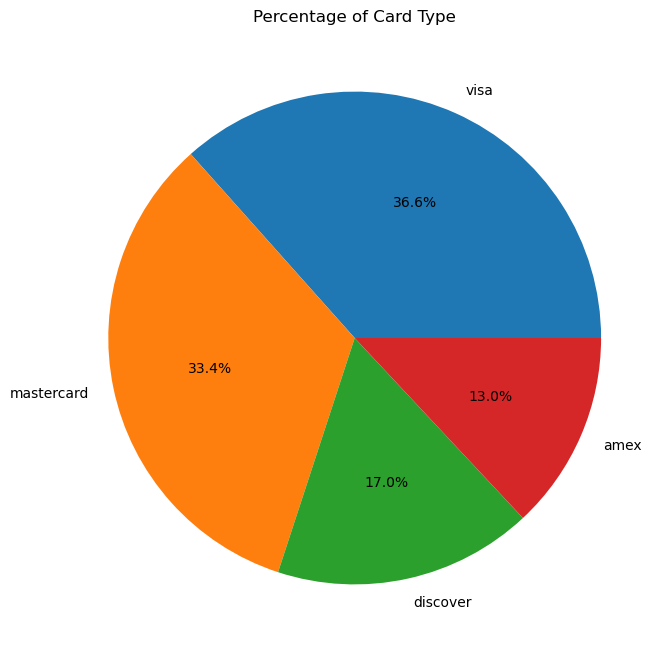

In [15]:
plt.figure(figsize=(8, 8))
plt.pie(df_card_dist['count'], labels=df_card_dist['card_type'], autopct='%1.1f%%')
plt.title('Percentage of Card Type')
plt.show()

### Question 5: Which Cities Have the Best Transction Approval Rates?

In [16]:
query_city_success = """
SELECT city, 
ROUND(AVG(CASE WHEN status='success' THEN 1 ELSE 0 END) * 100, 2) AS success_rate,
COUNT(*) AS count
FROM transactions
WHERE city IS NOT NULL
GROUP BY city
ORDER BY success_rate DESC;
"""

df_city_success = run_query(query_city_success)
df_city_success

/var/folders/jl/0pcs15c1273ff7zrhldsn30c0000gn/T/ipykernel_78313/1750610296.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(query, connection)


,city,success_rate,count
0,tehran,47.30,3478
1,ahvaz,46.99,632
2,mashhad,46.33,900
3,karaj,46.19,1037
4,tabriz,46.13,1368
5,isfahan,45.85,1073
6,shiraz,44.98,727
7,qom,44.54,669


## Key Findings & Conclusions

**Data Quality:**
- Started with 10,000 messy transaction records
- Cleaned inconsistent values across status, card types, and city names
- Handled 311 missing card_type values and 116 missing city values

**Business Insights:**
- **Overall Success Rate:** 46.34% - roughly half of transactions fail
- **Top City:** Tehran dominates with 3,478 transactions (35% of total)
- **Card Performance:** Amex had the highest success rate and Visa had the lowest
- **City Performance:** Tehran had the highest success rate and Qom had the lowest

**Recommendations:**
- Investigate why success rate is so low (46%)
- Focus on improving performance in high-volume cities

**Technical Skills Demonstrated:**
- Data cleaning with Python/pandas
- MySQL database design and querying
- SQL aggregations, GROUP BY, CASE statements
- Data visualization with matplotlib